## Notebook to integrate multiome objects (Seurat/Signac)

- Last updated: 02/06/2024
- Author: Yang-Joon Kim

- Step 1. load the multiome objects from all timepoints (6 timepoints, 2 replicates from 15-somites)
- Step 2. re-process the ATAC objects (merging peaks, re-computing the count matrices, then re-computing the PCA/LSI/SVD, seurat integration).
- Step 3. integrate the RNA objects (seurat integration using rPCA or CCA)
- Step 4. generate QC metric plots (RNA and ATAC)
- Step 5. (optional - another notebook) alignUMAP for individual timepoints

In [ ]:
# load the libraries
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
library(SeuratData)
library(SeuratDisk)
library(Matrix)

# genome info
library(GenomeInfoDb)
library(ggplot2)
library(patchwork)
library(stringr)
library(BSgenome.Drerio.UCSC.danRer11)

print(R.version)
print(packageVersion("Seurat"))

# parallelization in Signac: https://stuartlab.org/signac/articles/future
library(future)
plan()

plan("multicore", workers = 8)
plan()

# set the max memory size for the future
options(future.globals.maxSize = 80 * 1024 ^ 3) # for 80 Gb RAM

## Step 1. Load datasets

In [2]:
# Load all seurat objects
TDR118 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR118reseq/TDR118_processed.RDS")
TDR119 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR119reseq/TDR119_processed.RDS")
TDR124 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR124reseq/TDR124_processed.RDS")
TDR125 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR125reseq/TDR125_processed.RDS")
TDR126 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR126/TDR126_processed.RDS")
TDR127 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR127/TDR127_processed.RDS")
TDR128 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR128/TDR128_processed.RDS")

In [3]:
TDR118[["ATAC"]]

ChromatinAssay data with 248320 features for 13614 cells
Variable features: 0 
Genome: GRCz11 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

In [6]:
TDR118[["peaks_merged"]]

ChromatinAssay data with 485357 features for 13614 cells
Variable features: 485357 
Genome: GRCz11 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

In [4]:
# extract only "ATAC" modality for simpler processing
TDR118_ATAC <- TDR118[["peaks_merged"]]
TDR119_ATAC <- TDR119[["peaks_merged"]]
TDR124_ATAC <- TDR124[["peaks_merged"]]
TDR125_ATAC <- TDR125[["peaks_merged"]]
TDR126_ATAC <- TDR126[["peaks_merged"]]
TDR127_ATAC <- TDR127[["peaks_merged"]]
TDR128_ATAC <- TDR128[["peaks_merged"]]


## Step 2. Integrate ATAC modality

The first step in ATAC data integration is creating a common peak set. 
Description from Signac (https://stuartlab.org/signac/0.2/articles/merging):

If the peaks were identified independently in each experiment then they will likely not overlap perfectly. We can merge peaks from all the datasets to create a common peak set, and quantify this peak set in each experiment prior to merging the objects.

There are a few different ways that we can create a common peak set. One possibility is using the reduce or disjoin functions from the GenomicRanges package. The UnifyPeaks function extracts the peak coordinates from a list of objects and applies reduce or disjoin to the peak sets to create a single non-overlapping set of peaks.

### NOTE. Step 2 is a memory heavy job (400GB), and takes about several hours.

In [5]:
# creating a common peak set
combined.peaks <- UnifyPeaks(object.list = list(TDR118_ATAC,TDR119_ATAC,TDR124_ATAC,
                                                TDR125_ATAC,TDR126_ATAC,TDR127_ATAC,
                                                TDR128_ATAC), mode = "reduce")
combined.peaks

GRanges object with 640834 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]        1            32-526      *
       [2]        1         2372-3057      *
       [3]        1         3427-4032      *
       [4]        1         4469-7268      *
       [5]        1         9541-9969      *
       ...      ...               ...    ...
  [640830]       25 37498106-37500090      *
  [640831]       25 37500598-37500859      *
  [640832]       25 37501104-37501839      *
  [640833]       MT           22-3567      *
  [640834]       MT       13233-16532      *
  -------
  seqinfo: 26 sequences from an unspecified genome; no seqlengths

### Step 2-2. quantify peaks in each dataset (re-process the count matrices)

Using the re-defined peak set, we will re-compute the count matrices (cells-by-peaks).


In [9]:
# define a function to quantify the peaks
recompute_count_matrices <- function(seurat_obj, combined.peaks, data_id){
    new.counts <- FeatureMatrix(
      fragments = Fragments(seurat_obj),
      features = combined.peaks,
      sep = c(":", "-"),
      cells = colnames(seurat_obj)
    )
    seurat_obj[["peaks_integreated"]] <- CreateAssayObject(counts = new.counts)
    # add the data_id to the object
    seurat_obj$dataset <- data_id
    return(seurat_obj)
}

In [ ]:
TDR118_ATAC <- recompute_count_matrices(TDR118_ATAC, combined.peaks = combined.peaks)


Extracting reads overlapping genomic regions



In [ ]:
TDR118_ATAC

In [3]:
# recompute the count matrices for each dataset, save as "peaks_integrated" ChromatinAssay
TDR118_ATAC <- recompute_count_matrices(TDR118_ATAC, combined.peaks = combined.peaks)
TDR119_ATAC <- recompute_count_matrices(TDR119_ATAC, combined.peaks = combined.peaks)
TDR124_ATAC <- recompute_count_matrices(TDR124_ATAC, combined.peaks = combined.peaks)
TDR125_ATAC <- recompute_count_matrices(TDR125_ATAC, combined.peaks = combined.peaks)
TDR126_ATAC <- recompute_count_matrices(TDR126_ATAC, combined.peaks = combined.peaks)
TDR127_ATAC <- recompute_count_matrices(TDR127_ATAC, combined.peaks = combined.peaks)
TDR128_ATAC <- recompute_count_matrices(TDR128_ATAC, combined.peaks = combined.peaks)


### merging all objects (concatenation of count matrices)

In [ ]:
# merge all datasets, adding a cell ID to make sure cell names are unique
combined <- merge(x = TDR118_ATAC, 
                    y = list(TDR119_ATAC, TDR124_ATAC, TDR125_ATAC,
                            TDR126_ATAC, TDR127_ATAC, TDR128_ATAC), 
                            add.cell.ids = c("TDR118", "TDR119", "TDR124", "TDR125", "TDR126", "TDR127", "TDR128"))

saveRDS(combined, "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_ATAC.RDS")  # save the combined object
print("Saved the combined object")

### computing dimensionality reduction

In [2]:
combined <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_ATAC.RDS")

In [4]:
combined

An object of class Seurat 
640834 features across 95196 samples within 1 assay 
Active assay: peaks_integrated (640834 features, 0 variable features)

In [ ]:
# make sure to change to the assay containing common peaks
DefaultAssay(combined) <- "peaks_integrated"
combined <- RunTFIDF(combined)
combined <- FindTopFeatures(combined, min.cutoff = 20)
combined <- RunSVD(
  combined,
  reduction.key = 'LSI_',
  reduction.name = 'lsi',
  irlba.work = 400
)
combined <- RunUMAP(combined, dims = 2:40, reduction = 'lsi')

DimPlot(combined, group.by = 'dataset', pt.size = 0.1)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:54:43 UMAP embedding parameters a = 0.9922 b = 1.112

14:54:43 Read 95196 rows and found 39 numeric columns

14:54:43 Using Annoy for neighbor search, n_neighbors = 30

14:54:43 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:55:32 Writing NN index file to temp file /tmp/RtmpvqBrNv/file3967ba192dbfeb

14:55:32 Searching Annoy index using 8 threads, search_k = 3000

14:56:12 Annoy recall = 100%

14:56:13 Commencin

In [ ]:
saveRDS(combined, "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_ATAC.RDS")  # save the combined object
print("Saved the combined object with LSI and UMAP")

In [8]:
combined_ATAC <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_ATAC.RDS")
combined_ATAC

An object of class Seurat 
640834 features across 95196 samples within 1 assay 
Active assay: peaks_integrated (640834 features, 640778 variable features)
 2 dimensional reductions calculated: lsi, umap

In [15]:
# combined_ATAC@assays$peaks_integrated@counts

# NOTE: @counts layer stores "raw counts", "data" layer likely stores log-normalized counts, and "scale.data" layer stores the scaled counts.

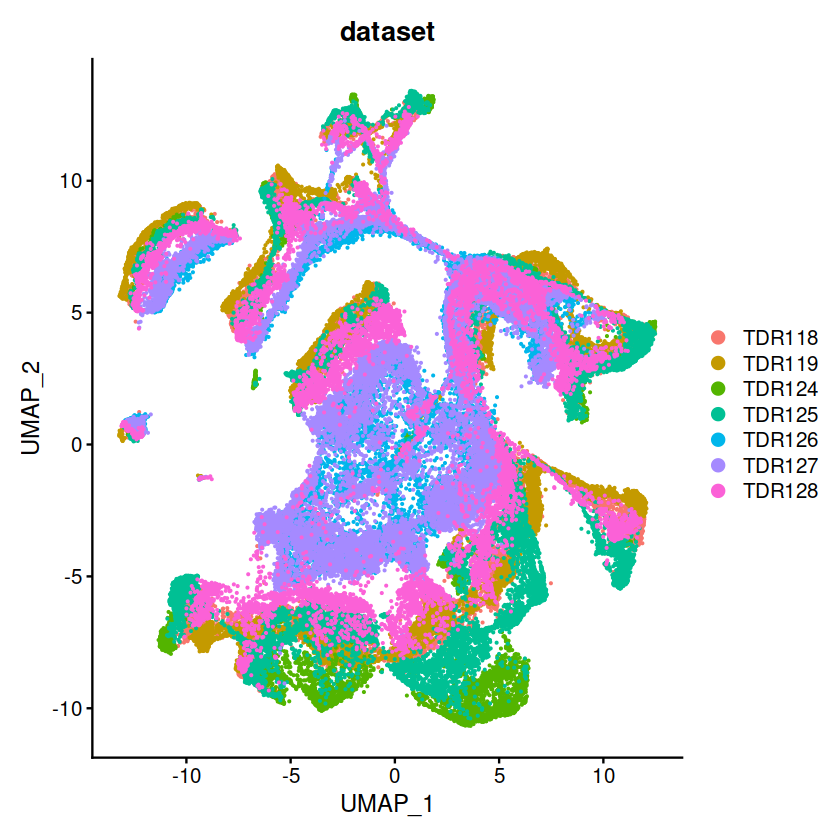

In [11]:
DimPlot(combined_ATAC, group.by = 'dataset', pt.size = 0.1)

In [31]:
combined_ATAC

An object of class Seurat 
640834 features across 95196 samples within 1 assay 
Active assay: peaks_integrated (640834 features, 640778 variable features)
 2 dimensional reductions calculated: lsi, umap

### NOTES: clearly, there's a batch effect, so we will integrate the datasets across timepoints using reciprocal LSI projection 

- source: https://stuartlab.org/signac/articles/integrate_atac

"To find integration anchors between the two datasets, we need to project them into a shared low-dimensional space. To do this, we’ll use reciprocal LSI projection (projecting each dataset into the others LSI space) by setting reduction="rlsi". For more information about the data integration methods in Seurat, see our recent paper and the Seurat website.

Rather than integrating the normalized data matrix, as is typically done for scRNA-seq data, we’ll integrate the low-dimensional cell embeddings (the LSI coordinates) across the datasets using the IntegrateEmbeddings() function. This is much better suited to scATAC-seq data, as we typically have a very sparse matrix with a large number of features. Note that this requires that we first compute an uncorrected LSI embedding using the merged dataset (as we did above)."

In [32]:
# combined<-combined_ATAC

# # Subset by dataset ID
# TDR118 <- subset(combined, subset = dataset == "TDR118")
# TDR119 <- subset(combined, subset = dataset == "TDR119")
# TDR124 <- subset(combined, subset = dataset == "TDR124")
# TDR125 <- subset(combined, subset = dataset == "TDR125")
# TDR126 <- subset(combined, subset = dataset == "TDR126")
# TDR127 <- subset(combined, subset = dataset == "TDR127")
# TDR128 <- subset(combined, subset = dataset == "TDR128")

# # find integration anchors
# integration.anchors <- FindIntegrationAnchors(
#   object.list = list(TDR118,TDR119,TDR124,TDR125,TDR126,TDR127,TDR128),
#   anchor.features = rownames(TDR118), # all features (combined.peaks)
#   reduction = "rlsi", # reciprocal LSI
#   dims = 2:30
# )
# print("anchors computed")

# # integrate LSI embeddings
# integrated <- IntegrateEmbeddings(
#   anchorset = integration.anchors,
#   reductions = combined[["lsi"]],
#   new.reduction.name = "integrated_lsi",
#   dims.to.integrate = 1:30
# )
# print("integration completed")

# # create a new UMAP using the integrated embeddings
# integrated <- RunUMAP(integrated, reduction = "integrated_lsi", dims = 2:30)
# # p2 <- DimPlot(integrated, group.by = "dataset")
# saveRDS(integrated, "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_ATAC_rLSI.RDS")  # save the combined object
# print("Saved the integrated object")

## NOTES:
- 1. The above code cell is integrated into the "integrate_seurat_timepoints_ATAC.R" script for slurm/HPC computing.
- 2. Note that the meta.data should be combined at the very beginning. For now, this will be done separately.

In [ ]:
integrated_ATAC <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_ATAC_rLSI.RDS")
integrated_ATAC

In [34]:
# Load all seurat objects
TDR118 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR118reseq/TDR118_processed.RDS")
TDR119 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR119reseq/TDR119_processed.RDS")
TDR124 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR124reseq/TDR124_processed.RDS")
TDR125 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR125reseq/TDR125_processed.RDS")
TDR126 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR126/TDR126_processed.RDS")
TDR127 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR127/TDR127_processed.RDS")
TDR128 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR128/TDR128_processed.RDS")

In [ ]:
# Step 1: Extract metadata from each object and add a dataset identifier
meta_TDR118 <- TDR118@meta.data
meta_TDR118$dataset <- "TDR118"

meta_TDR119 <- TDR119@meta.data
meta_TDR119$dataset <- "TDR119"

meta_TDR124 <- TDR124@meta.data
meta_TDR124$dataset <- "TDR124"

meta_TDR125 <- TDR125@meta.data
meta_TDR125$dataset <- "TDR125"

meta_TDR126 <- TDR126@meta.data
meta_TDR126$dataset <- "TDR126"

meta_TDR127 <- TDR127@meta.data
meta_TDR127$dataset <- "TDR127"

meta_TDR128 <- TDR128@meta.data
meta_TDR128$dataset <- "TDR128"

# Step 2: Merge all metadata frames
combined_metadata <- rbind(meta_TDR118, meta_TDR119, meta_TDR124, meta_TDR125, meta_TDR126, meta_TDR127, meta_TDR128)

# Assuming the row names of combined_metadata are the cell names, if not, adjust as necessary

# Step 3: Ensure the merged metadata is correctly ordered to match the combined Seurat object
# This step is crucial for aligning the metadata with the cell names in the combined Seurat object
# Make sure the cell names (rownames) in combined@meta.data match those in the combined Seurat object
combined_metadata_ordered <- combined_metadata[match(rownames(combined@meta.data), rownames(combined_metadata)), ]

# Verify that the order is correct (optional but recommended)
all(rownames(combined@meta.data) == rownames(combined_metadata_ordered))

# Step 4: Assign the ordered metadata back to the combined Seurat object
combined@meta.data <- combined_metadata_ordered

In [ ]:
# save the updated object with meta.data


## Step 3. Integrate RNA modality

- since this was also memory heavy, we ran this part using slurm on HPC.

In [ ]:
# # load the libraries
# suppressMessages(library(Seurat))
# suppressMessages(library(Signac))
# library(SeuratData)
# library(SeuratDisk)
# library(Matrix)

# # genome info
# library(GenomeInfoDb)
# library(ggplot2)
# library(patchwork)
# library(stringr)
# library(BSgenome.Drerio.UCSC.danRer11)

# print(R.version)
# print(packageVersion("Seurat"))

# # parallelization in Signac: https://stuartlab.org/signac/articles/future
# library(future)
# plan()

# plan("multicore", workers = 8)
# plan()

# # set the max memory size for the future
# options(future.globals.maxSize = 512 * 1024 ^ 3) # for  Gb RAM

# Step 1. Load the datasets
# Load all seurat objects (replace the filepaths if you use this for your own datasets)
TDR118 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR118reseq/TDR118_processed.RDS")
TDR119 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR119reseq/TDR119_processed.RDS")
TDR124 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR124reseq/TDR124_processed.RDS")
TDR125 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR125reseq/TDR125_processed.RDS")
TDR126 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR126/TDR126_processed.RDS")
TDR127 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR127/TDR127_processed.RDS")
TDR128 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR128/TDR128_processed.RDS")

print("Loaded all the datasets")

# change the default assay to "SCT" (post-normalization and scaling)
DefaultAssay(TDR118) <- "SCT"
DefaultAssay(TDR119) <- "SCT"
DefaultAssay(TDR124) <- "SCT"
DefaultAssay(TDR125) <- "SCT"
DefaultAssay(TDR126) <- "SCT"
DefaultAssay(TDR127) <- "SCT"
DefaultAssay(TDR128) <- "SCT"

# Step 2. Integrate the RNA objects
print(paste("Integration ... "))
# 2-1. Load the list of objects
danio.list <- list(TDR118, TDR119, TDR124, TDR125, TDR126, TDR127, TDR128)


# 2-2. Find integration anchors and integrate data 
# Get the index for the "10hpf" entry
# index_10hpf <- which(names(danio.list) == "TDR126")
# index_10hpf

# # Get the index for the "24hpf" entry
# index_24hpf <- which(names(danio.list) == "TDR124")
# index_24hpf

# find the highly variable features
features <- SelectIntegrationFeatures(object.list = danio.list)

# find the integration anchors
danio.anchors <- FindIntegrationAnchors(object.list = danio.list, anchor.features = features,
                                       normalization.method = 'LogNormalize', #c("LogNormalize", "SCT"),
                                       dims = 1:30, # default 1:30
                                       k.anchor = 5, #default 5
                                       k.filter = 200, #default 200 for a query cell, If the anchor reference cell is found within the first k.filter (200) neighbors, then we retain this anchor.
                                       k.score = 30, # default 30: For each reference anchor cell, we determine its k.score (30) nearest within-dataset neighbors and its k.score nearest neighbors in the query dataset
                                       reduction = "rpca", # default cca, rpca should be faster 
                                       #reference = c(index_10hpf,index_24hpf) # the 10hpf and 24hpf timepoints as "references" that other datasets will be anchored against
                                       )
# Integreate the datasets using "anchors" computed above
seurat_combined <- IntegrateData(anchorset = danio.anchors, 
                                new.assay.name = "integrated",
                                dims=1:30,
                                k.weight = 30)

# 3. Generate an integrated embedding: run PCA on integrated (corrected) counts 
# specify that we will perform downstream analysis on the corrected data note that the
# original unmodified data still resides in the 'RNA' assay
DefaultAssay(seurat_combined) <- "integrated"

# Run the standard workflow for visualization and clustering
seurat_combined <- ScaleData(seurat_combined, verbose = FALSE)
seurat_combined <- RunPCA(seurat_combined, npcs = 100, verbose = FALSE)
print(paste("Runnning UMAP on the integrated PCA embedding..."))

# 4. UMAP on integrated embbedding 
seurat_combined <- RunUMAP(seurat_combined, reduction = "pca", dims = 1:30,
                             metric='euclidean',
                             n.neighbors = 30,
                             local.connectivity  =1, # 1 default
                             repulsion.strength = 1, # 1 default
                         )
seurat_combined <- FindNeighbors(seurat_combined, reduction = "pca", dims = 1:30)
seurat_combined <- FindClusters(seurat_combined, resolution = 0.5)

print(paste("plotting UMAP with different batch keys..."))
# Check the integrated UMAP
plot1 <- DimPlot(seurat_combined, dims = c(1, 2), group.by = "timepoint")
plot2 <- DimPlot(seurat_combined, dims = c(1, 2), group.by = "fish")
#plot3 <- DimPlot(seurat_combined, dims = c(1, 2), group.by = "leiden")
plot1 + plot2 #+ plot3

# 5. Export R object 
# name of the output file
saveRDS(seurat_combined, file = paste0("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/","integrated_RNA.rds")) 
print(paste("RDS object saved"))



## Step 4. generate QC metric plots for RNA and ATAC

- 

In [ ]:
# RNA QC metrics


In [ ]:
# ATAC QC metrics
